In [1]:
# import the necessary packages

# from trainerCNN_SmallVGGNet import SmallVGGNet # custom
#Instead of from keras.models import Sequential , this time we import SmallVGGNet

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import cv2, pickle, os, random

In [2]:
data = []
labels = []

imagePaths = sorted(list(paths.list_images(r'animals/')))
random.seed(42)
random.shuffle(imagePaths)

#progressBar
pbar = tqdm(total=len(imagePaths), desc="🔃 Images: ")
for imagePath in imagePaths:
    image = cv2.resize(cv2.imread(imagePath), (64, 64)) #load and resize
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    
    pbar.update(1)
pbar.close()

🔃 Images:   0%|          | 0/3000 [00:00<?, ?it/s]

In [3]:
#scale the raw pixel intensities range 0 to 1
data = np.array(data, dtype = "float")/255.0
labels = np.array(labels)

In [5]:
labels = np.asarray(labels).reshape((-1 ,1))

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [7]:
# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [8]:
#image generator for data augmentation 
#Data augmentation is often a critical step to:
    # -Avoiding overfitting , Ensuring your model generalizes well
    
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [9]:
print(data.shape)
print(labels.shape)

(3000, 64, 64, 3)
(3000, 1)


In [10]:
# initialize our VGG-like Convolutional Neural Network
from trainerCNN_SmallVGGNet import SmallVGGNet
model = SmallVGGNet.build(width=64, height=64, channel=3, classes=len(lb.classes_))

In [13]:
initLR = 0.01
EPOCHS = 10  # make it around 70
BS = 32

print("🔃: init model and optimizer")
opt = SGD(lr = initLR, decay= initLR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

🔃: init model and optimizer


### <center>  Train the network

In [14]:
# train the network
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS)

Epoch 1/10
70/70 [==============================] - 34s 464ms/step - loss: 1.4699 - accuracy: 0.4861 - val_loss: 1.3838 - val_accuracy: 0.3693
Epoch 2/10
70/70 [==============================] - 34s 484ms/step - loss: 1.0300 - accuracy: 0.6005 - val_loss: 1.8689 - val_accuracy: 0.3107
Epoch 3/10
70/70 [==============================] - 32s 459ms/step - loss: 1.0283 - accuracy: 0.5743 - val_loss: 2.4170 - val_accuracy: 0.3173
Epoch 4/10
70/70 [==============================] - 33s 469ms/step - loss: 0.8948 - accuracy: 0.6047 - val_loss: 1.9862 - val_accuracy: 0.3293
Epoch 5/10
70/70 [==============================] - 33s 465ms/step - loss: 0.7762 - accuracy: 0.6351 - val_loss: 1.6595 - val_accuracy: 0.3547
Epoch 6/10
70/70 [==============================] - 33s 472ms/step - loss: 0.7426 - accuracy: 0.6620 - val_loss: 1.0975 - val_accuracy: 0.5000
Epoch 7/10
70/70 [==============================] - 32s 462ms/step - loss: 0.7785 - accuracy: 0.6374 - val_loss: 0.6732 - val_accuracy: 0.6840

 ### <center> evaluating network

In [15]:
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

               precision    recall  f1-score   support

 animals/cats       0.59      0.82      0.69       236
 animals/dogs       0.69      0.42      0.52       236
animals/panda       0.88      0.88      0.88       278

     accuracy                           0.72       750
    macro avg       0.72      0.71      0.70       750
 weighted avg       0.73      0.72      0.71       750



#### <center> Plot the training loss and accuracy

[INFO] serializing network and label binarizer...


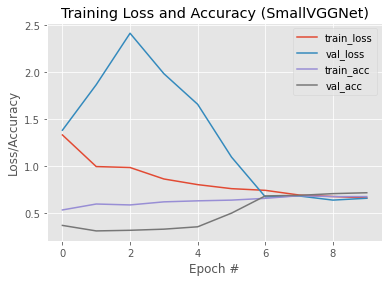

In [17]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (SmallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(r"trainOutput/scores_CNNVGGTest.png")

# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save(r'trainOutput/CNNSmallVGGNet.model', save_format="h5")
f = open(r'trainOutput/CNNSmallVGGNet_lb.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()